# HW10_Assignment1_zn352 - Spatial Data Analysis (Winter Season)
Exploratory spatial data analysis of CitiBike data using pysal and geopandas

## Import initial libraries

In [168]:
%matplotlib inline
import numpy as np
import pandas as pd
import os
from pandas import DataFrame
import matplotlib.pylab as plt
plt.style.use('ggplot')

## Working with Shape File

### Loading Census Tract Shape File¶

In [169]:
from geopandas import GeoDataFrame
shape_path = "Data/ct_shape.shp"  #I store the file in 'Data' folder
ct_shape = GeoDataFrame.from_file(shape_path)
ct_shape.index=ct_shape.BoroCT2010

### Coordinate systems, projections, and transformations 

In [170]:
from fiona.crs import from_epsg
ct_shape.crs = from_epsg(4326) # epsg=4326: lat/on | 26918: NAD83/UTM zone 18N | epsg=2263 is US feet
# incase the file does not have a coordinate system 

NYC_Area=ct_shape.to_crs(epsg=2263).geometry.area.sum()/(2.788*10**7) # from ft2 to mi2 
print 'total NYC land area: %s (mi^2)'%str(NYC_Area)[:5] # from ft2 to mi2 #epsg=2263 is US feet

total NYC land area: 302.3 (mi^2)


### Visualize the Cencus Tract boundaries colored by boroughs

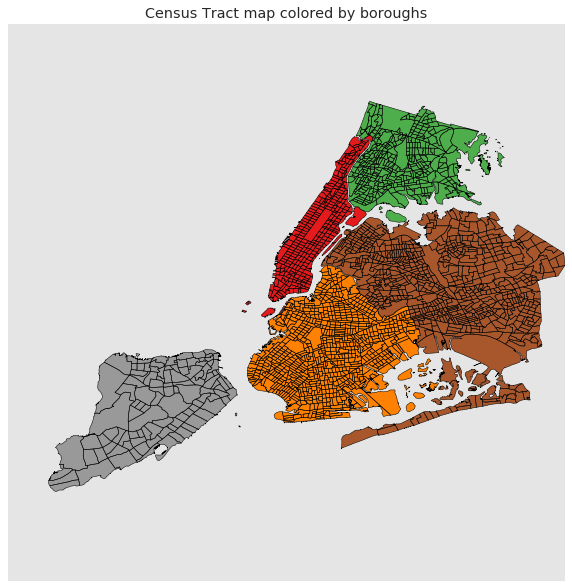

In [171]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape.plot(column='BoroCode',alpha=1,linewidth=0.5,ax=ax)
plt.title("Census Tract map colored by boroughs")

Figure 1 - NYC Census Tract Map by Borough

### Map NYC Population density

#### Load Census Data for 2010

In [172]:
ct_data=DataFrame.from_csv('Data/ACS_CT2010.csv')
#set index to be the BoroCT2010 code
ct_data.index=ct_data.BoroCT2010.astype(str)

#### Add popuation density to CT shapefile

In [173]:
ct_shape_pop=ct_shape.join(ct_data[['SE_T002_002']]) #SE_T002_002 is population density in social explorer dataset

#### Vusualize the Population density for 2010

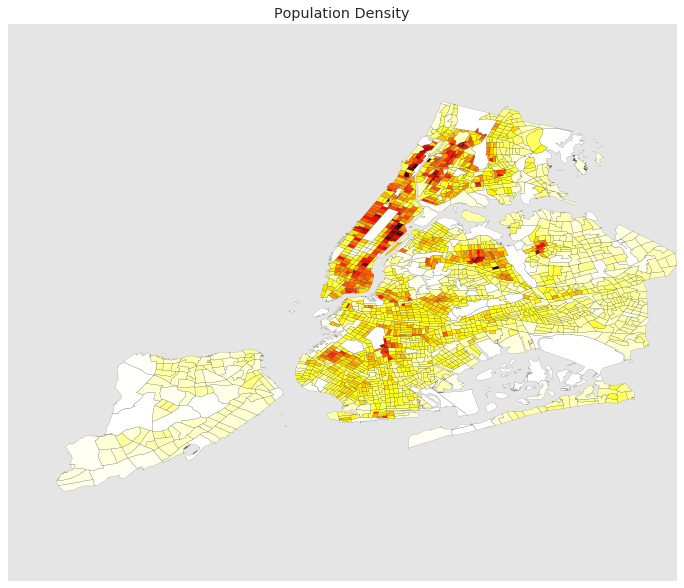

In [174]:
f, ax = plt.subplots(figsize=(12,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape_pop.plot(column='SE_T002_002',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax)
plt.title("Population Density")

Figure 2 - Population Density Map in NYC

## Explore CitiBike data

### Load CitiBike data

In [175]:
df_bike_monthly = DataFrame.from_csv('Data/CitiBike_monthly_byStation.csv')
df_bike_monthly.head()

,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,...,1533,1534,1535,1536,1537,1538,1539,1540,1541,1542
starttime,,,,,,,,,,,,,,,,,,,,,
2013-07-31,2343,3914,6979,2750,4914,2229,2183,3139,3622,2368,...,0,0,0,0,0,0,0,0,0,0
2013-08-31,2696,4429,9020,3433,6645,2768,2761,3422,4271,2910,...,0,0,0,0,0,0,0,0,0,0
2013-09-30,2878,5258,9814,3739,7837,3206,2747,3590,4618,2885,...,0,0,0,0,0,0,0,0,0,0
2013-10-31,2920,4409,10456,3520,8928,3237,2530,3909,4169,2542,...,0,0,0,0,0,0,0,0,0,0
2013-11-30,1883,2731,6384,2446,5201,2085,1415,2727,3146,1539,...,0,0,0,0,0,0,0,0,0,0


### Time Series Aanalysis

/opt/rh/anaconda/root/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.


(-200, 16000)

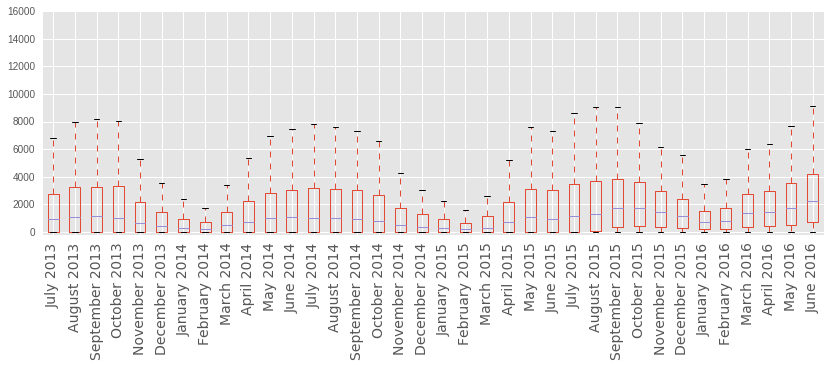

In [176]:
plt.rcParams['font.size']=14
f, ax = plt.subplots(figsize=(14,4))
#create a copy of the df for the viz purposes
df_bike_monthly_ = df_bike_monthly.copy()
df_bike_monthly_.index = df_bike_monthly_.index.strftime("%B %Y")
df_bike_monthly_.T.boxplot(figsize=(15,7),ax=ax,rot=90);
ax.set_ylim([-200,16000])

Figure 3 - Map of Citi Bike Monthly Usage

#### Seasonal Decomposition

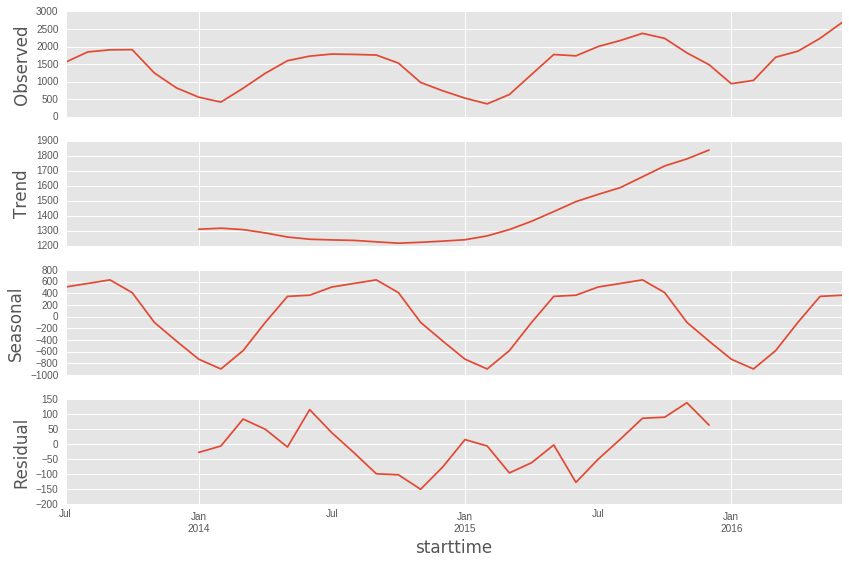

In [177]:
import statsmodels.api as sm

#Create a monthly time series of bike ride (Average of all citibike stations)
df_new=df_bike_monthly.mean(1).resample('M').mean()
df_new.interpolate(inplace=True)

#Seasonal Decomposition using statsmodels api
res = sm.tsa.seasonal_decompose(df_new.dropna())
plt.rcParams['figure.figsize']=(12,8)
resplot = res.plot()

Figure 4 - Time Series Analysis of Monthly Citi Bike Usage, with Seasonal and Trend Decomposition.

### From Figure 3 and Figure 4 we observe a significant periodicity between seasons. Summer time (start from July to September) often has the highest peak in usage, while winter/spring (start from Jan to March) has the lowest usage of Citi Bike. 
### I will analysis average winter usage from January to March of year 2014 to 2016

### Sum up seasonal data

In [178]:
pd.to_datetime(df_bike_monthly.index)

DatetimeIndex(['2013-07-31', '2013-08-31', '2013-09-30', '2013-10-31',
               '2013-11-30', '2013-12-31', '2014-01-31', '2014-02-28',
               '2014-03-31', '2014-04-30', '2014-05-31', '2014-06-30',
               '2014-07-31', '2014-08-31', '2014-09-30', '2014-10-31',
               '2014-11-30', '2014-12-31', '2015-01-31', '2015-02-28',
               '2015-03-31', '2015-04-30', '2015-05-31', '2015-06-30',
               '2015-07-31', '2015-08-31', '2015-09-30', '2015-10-31',
               '2015-11-30', '2015-12-31', '2016-01-31', '2016-02-29',
               '2016-03-31', '2016-04-30', '2016-05-31', '2016-06-30'],
              dtype='datetime64[ns]', name=u'starttime', freq=None)

In [179]:
TS = df_bike_monthly.index.to_period('Q-DEC') #set quarterly time series start from 2013-Jul

In [180]:
TS

PeriodIndex(['2013Q3', '2013Q3', '2013Q3', '2013Q4', '2013Q4', '2013Q4',
             '2014Q1', '2014Q1', '2014Q1', '2014Q2', '2014Q2', '2014Q2',
             '2014Q3', '2014Q3', '2014Q3', '2014Q4', '2014Q4', '2014Q4',
             '2015Q1', '2015Q1', '2015Q1', '2015Q2', '2015Q2', '2015Q2',
             '2015Q3', '2015Q3', '2015Q3', '2015Q4', '2015Q4', '2015Q4',
             '2016Q1', '2016Q1', '2016Q1', '2016Q2', '2016Q2', '2016Q2'],
            dtype='int64', name=u'starttime', freq='Q-DEC')

In [181]:
df_bike_seasonal = df_bike_monthly.groupby(TS).sum()

In [182]:
df_bike_seasonal.head()

,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,...,1533,1534,1535,1536,1537,1538,1539,1540,1541,1542
starttime,,,,,,,,,,,,,,,,,,,,,
2013Q3,7917,13601,25813,9922,19396,8203,7691,10151,12511,8163,...,0,0,0,0,0,0,0,0,0,0
2013Q4,6102,8790,20921,7652,17175,6897,4775,8526,9363,5090,...,0,0,0,0,0,0,0,0,0,0
2014Q1,2410,3856,11200,3368,6371,3540,1834,4461,4150,2091,...,0,0,0,0,0,0,0,0,0,0
2014Q2,5063,8746,25752,9001,17941,8105,5383,10569,10557,6024,...,0,0,0,0,0,0,0,0,0,0
2014Q3,6712,9898,30378,10762,22082,10230,6625,11922,11557,6751,...,0,0,0,0,0,0,0,0,0,0


In [183]:
df_bike_seasonal.index

PeriodIndex(['2013Q3', '2013Q4', '2014Q1', '2014Q2', '2014Q3', '2014Q4',
             '2015Q1', '2015Q2', '2015Q3', '2015Q4', '2016Q1', '2016Q2'],
            dtype='int64', name=u'starttime', freq='Q-DEC')


### I am analyzing Summer Data, there for to calculate 2014Q1, 2015Q1, 2016Q1. 

## Winter

In [188]:
# create a new dataframe for winter data
df_bike_winter = df_bike_seasonal[df_bike_seasonal.index=='2014Q1']

In [189]:
# append dataframe for each row
df_bike_winter = df_bike_winter.append(df_bike_seasonal[df_bike_seasonal.index=='2015Q1'])

In [190]:
df_bike_winter = df_bike_winter.append(df_bike_seasonal[df_bike_seasonal.index=='2016Q1'])

In [191]:
df_bike_winter

,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,...,1533,1534,1535,1536,1537,1538,1539,1540,1541,1542
starttime,,,,,,,,,,,,,,,,,,,,,
2014Q1,2410,3856,11200,3368,6371,3540,1834,4461,4150,2091,...,0,0,0,0,0,0,0,0,0,0
2015Q1,2407,0,8890,3562,5556,4616,1415,4389,3762,1835,...,0,0,0,0,0,0,0,0,0,0
2016Q1,4122,6801,17167,6464,9393,7859,3148,9314,0,3911,...,0,0,0,0,0,0,0,0,0,0


## Map CitiBike Data to CT level

### Load CitiBike station location data

In [192]:
station_id=DataFrame.from_csv('Data/Station_id.csv')
#convert station_ids to string index
station_id.index=station_id.index.astype(str)
station_id.head()

,lat,lon
1000,40.753231,-73.970325
1001,40.749718,-74.002950
1002,40.730287,-73.990765
1003,40.718939,-73.992663
1004,40.734927,-73.992005


### Create CitiBike station Geometry (Point) from Corrdinates (Lat & Lon)

In [193]:
import shapely
# combine lat and lon to one column
station_id['lonlat']=zip(station_id.lon,station_id.lat)
# Create Point Geometry for based on lonlat column
station_id['geometry']=station_id[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))
station_id.head()

,lat,lon,lonlat,geometry
1000,40.753231,-73.970325,"(-73.97032517, 40.75323098)",POINT (-73.97032517 40.75323098)
1001,40.749718,-74.002950,"(-74.002950346, 40.749717753)",POINT (-74.00295034600001 40.749717753)
1002,40.730287,-73.990765,"(-73.9907647, 40.73028666)",POINT (-73.9907647 40.73028666)
1003,40.718939,-73.992663,"(-73.99266288, 40.71893904)",POINT (-73.99266288 40.71893904)
1004,40.734927,-73.992005,"(-73.99200509, 40.73492695)",POINT (-73.99200509000001 40.73492695)


### Intersect the two geometries

In [194]:
a=[]
# check for each citibike stations to see what CT they are belong to
for i in range(len(station_id)):
    a.append(ct_shape[ct_shape.geometry.intersects(station_id.iloc[i].geometry)].BoroCT2010.values[0])
    print '\r',"%",str((i+1)*100./len(station_id))[:4],
station_id['BoroCT2010']=a

% 100.


In [195]:
station_id.BoroCT2010.head()

1000    1009000
1001    1009900
1002    1005700
1003    1001800
1004    1006100
Name: BoroCT2010, dtype: object

### Add Monthly rides to the station GeoDataFrame with CT code

In [196]:
### Create average winter rides column from winter citibike data and add it to the station id which has the geometry
station_id['WinterAve'] = df_bike_winter.mean()

In [197]:
station_id.head()

,lat,lon,lonlat,geometry,BoroCT2010,WinterAve
1000,40.753231,-73.970325,"(-73.97032517, 40.75323098)",POINT (-73.97032517 40.75323098),1009000,2979.666667
1001,40.749718,-74.002950,"(-74.002950346, 40.749717753)",POINT (-74.00295034600001 40.749717753),1009900,3552.333333
1002,40.730287,-73.990765,"(-73.9907647, 40.73028666)",POINT (-73.9907647 40.73028666),1005700,12419.000000
1003,40.718939,-73.992663,"(-73.99266288, 40.71893904)",POINT (-73.99266288 40.71893904),1001800,4464.666667
1004,40.734927,-73.992005,"(-73.99200509, 40.73492695)",POINT (-73.99200509000001 40.73492695),1006100,7106.666667


### Add the winter average rides to the CT shapefile 

In [198]:

temp=station_id[['WinterAve']]
temp['station_id']=station_id.index
temp.index=station_id['BoroCT2010']
ct_shape_WinterAve=ct_shape.join(temp)
ct_shape_WinterAve.fillna(0,inplace=True)

/opt/rh/anaconda/root/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


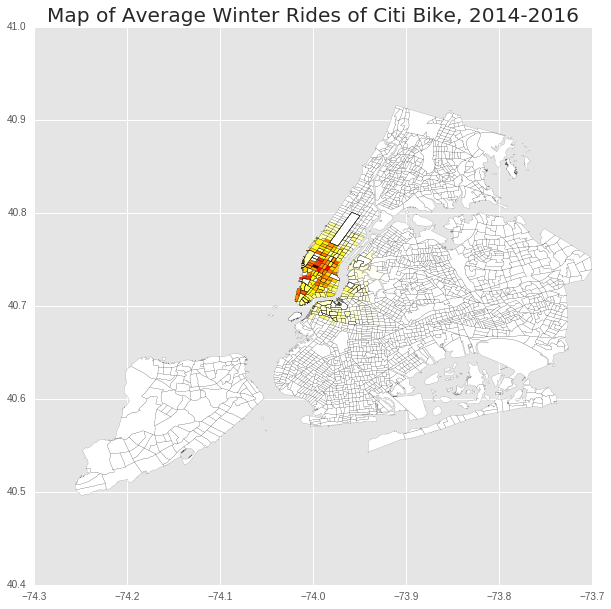

In [200]:
f, ax = plt.subplots(figsize=(10,10))
ct_shape_WinterAve.plot(column='WinterAve',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax)
plt.title('Map of Average Winter Rides of Citi Bike, 2014-2016')

Figure 5 - Average Citi Bike Ridership in Winter, NYC (2014-2016) 

### Removing the CTs that are out of zoom boundries

In [201]:
# zoom? 
ct_shape_WinterAve_Zoom=(ct_shape_WinterAve[ct_shape_WinterAve
                           .centroid
                           .apply(lambda c:c.x>-74.1 and c.x<-73.92 and c.y>40.65 and c.y<40.8)])

In [202]:
print "Total number of CTs:", len(ct_shape)
print "Number of zoomed CTs:", len(temp.WinterAve)

Total number of CTs: 2166
Number of zoomed CTs: 543


### Map the winter rides 

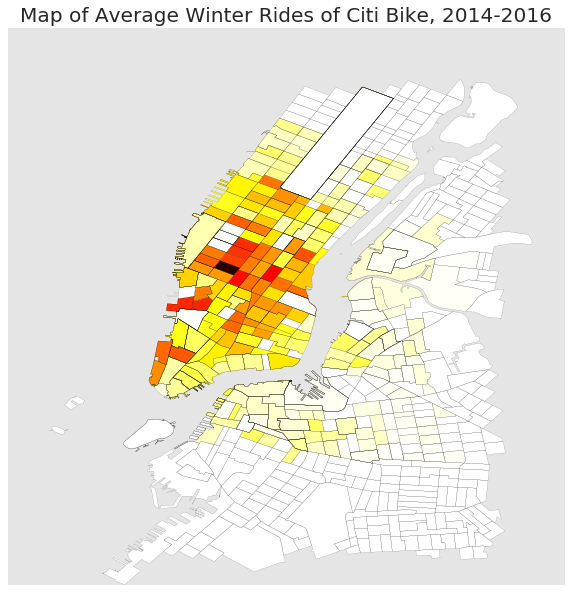

In [203]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape_WinterAve_Zoom.plot(column='WinterAve',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax)
plt.title('Map of Average Winter Rides of Citi Bike, 2014-2016')
plt.savefig('HW10_winterplot_zn352.png')

Figure 6 - Average Citi Bike Ridership in Summer, NYC (2014-2016)

### Export Shapefile CTs in the CitiBike Zone

In [204]:
path = 'Data/ct_shape_WinterAve_Zoom2.shp'
ct_shape_WinterAve_Zoom.to_file(path)

## Exploratory Geospatial Analysis

In [205]:
import pysal as ps

### Spatial Weights
Contiguity: Queen Weights

In [206]:
qW_CT=ps.queen_from_shapefile(path)

('Island id: ', [0])


#### Neighbors of index10

In [207]:
qW_CT[10]

{1: 1.0, 8: 1.0, 9: 1.0, 18: 1.0, 19: 1.0, 30: 1.0, 37: 1.0, 38: 1.0, 39: 1.0}

In [208]:
qW_CT.cardinalities[10]

9

#### Matrix of Weights

In [209]:
Wmatrix, ids = qW_CT.full()

In [210]:
Wmatrix

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  1.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.]])

#### Change the matrix to be row-standardized

In [211]:
qW_CT.transform = 'r'

('WARNING: ', 0, ' is an island (no neighbors)')


### Spatial Lag  
Similarity of CT neibors can be meseard by means of spatial lag as follow:
$$BikeRideCountLag = \sum_j w_{i,j} BikeRideCount$$

In [212]:
WinterRide=ct_shape_WinterAve_Zoom.WinterAve
WinterRideLag=ps.lag_spatial(qW_CT, WinterRide)

#### Create Quantiles for maping

In [213]:
WinterRideLagQ10 = ps.Quantiles(WinterRideLag, k=10)
WinterRideLagQ10

                  Quantiles                  
 
 Lower              Upper               Count
           x[i] <=    0.000               159
   0.000 < x[i] <=   13.095                 2
  13.095 < x[i] <=  214.486                78
 214.486 < x[i] <=  514.077                80
 514.077 < x[i] <=  807.752                79
 807.752 < x[i] <= 1160.861                80
1160.861 < x[i] <= 2599.008                79
2599.008 < x[i] <= 3552.913                80
3552.913 < x[i] <= 4277.033                79
4277.033 < x[i] <= 6987.000                80

#### Map the winter rides lag

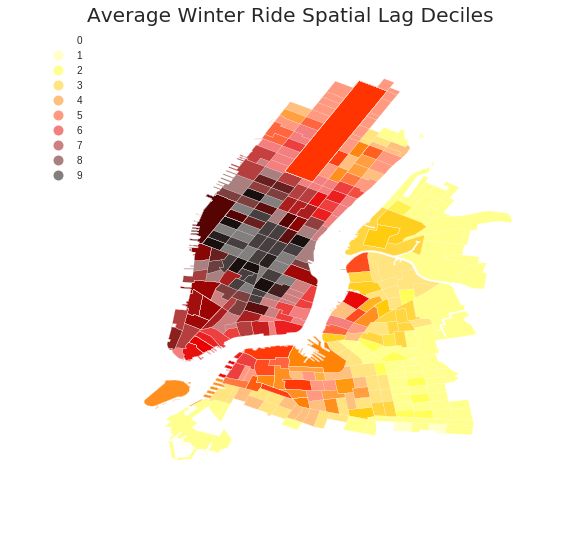

In [214]:
f, ax = plt.subplots(figsize=(9, 9))
ct_shape_WinterAve_Zoom.assign(cl=WinterRideLagQ10.yb).plot(column='cl', categorical=True, 
        k=10, cmap='hot_r', linewidth=0.1, ax=ax, 
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("Average Winter Ride Spatial Lag Deciles")
plt.savefig('HW10_winterlag_zn352.png')

Figure 7 - Spatial Lag Map by 10 Deciles, Average Citi Bike Ridership in Summer, NYC (2014-2016)

## Global  Spatial Autocorrelation

In [215]:
b,a = np.polyfit(WinterRide, WinterRideLag, 1)
b, a

(0.65936945695485016, 545.61613151533641)

### Moran Scatterplot

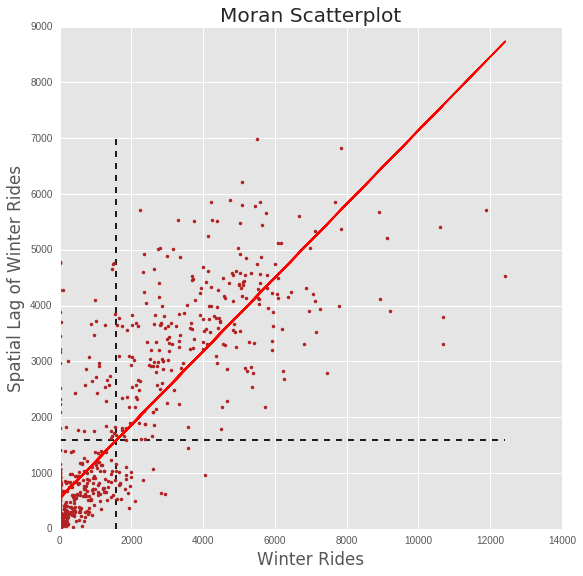

In [216]:
f, ax = plt.subplots(1, figsize=(9, 9))

plt.plot(WinterRide, WinterRideLag, '.', color='firebrick')

 # dashed vert at mean of the last year's PCI
plt.vlines(WinterRide.mean(), WinterRideLag.min(), WinterRideLag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(WinterRideLag.mean(), WinterRide.min(), WinterRide.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(WinterRide, a + b*WinterRide, 'r')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of Winter Rides')
plt.xlabel('Winter Rides')

Figure 8 - Moran Scatterplot, Average Citi Bike Ridership in Summer, NYC (2013-2016)

Shows a positive correlation

### Moran's I

In [217]:
I_WinterRide = ps.Moran(WinterRide, qW_CT)

In [218]:
I_WinterRide.I, I_WinterRide.p_sim #sim - significant level, p value

(0.65951383017490961, 0.001)

Thus, the $I$ statistic is $0.656$ for this data, and has a very small $p$ value. 

In [219]:
I_WinterRide.sim[0:10]

array([ 0.019919  , -0.00095894,  0.02312297, -0.03039925, -0.00681804,
        0.00280522,  0.01772904, -0.00525371,  0.02043555,  0.00913871])

### KDEplot of all of the simulated points
the vertical line shows the observed value

In [220]:
import seaborn as sns
plt.rcParams['figure.figsize']=(14,3)

(-0.7, 0.7)

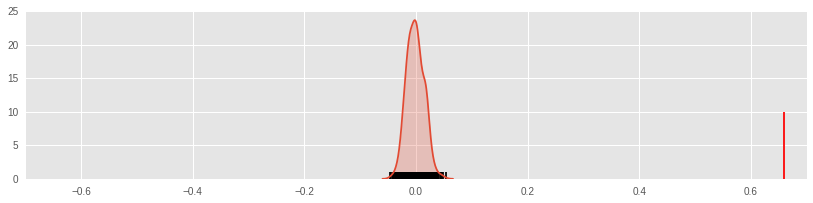

In [221]:
sns.kdeplot(I_WinterRide.sim, shade=True)
plt.vlines(I_WinterRide.sim, 0, 1)
plt.vlines(I_WinterRide.I, 0, 10, 'r')
plt.xlim([-.70, .70])

In the following figure the vertical line is showing if our $I$ statistic were close to our expected value

(-0.7, 0.7)

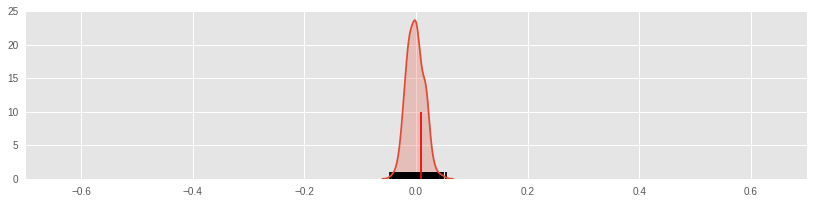

In [222]:
sns.kdeplot(I_WinterRide.sim, shade=True)
plt.vlines(I_WinterRide.sim, 0, 1)
plt.vlines(I_WinterRide.EI+.01, 0, 10, 'r')
plt.xlim([-.70, .70])

## Local  Spatial Autocorrelation

In [223]:
LMo_WinterRide = ps.Moran_Local(WinterRide, qW_CT, permutations=999)
# permutate 'my friends' from the 'poor' pool is called local permutatin instead of global per., return a correlation significance. 

In [224]:
LMo_WinterRide.Is[0:5], LMo_WinterRide.p_sim[0:5]

(array([-0.        , -0.32301466, -0.00151236,  0.00049853, -0.05866435]),
 array([ 0.001,  0.137,  0.413,  0.438,  0.423]))

### LISA (Local Indicators of Spatial Autocorrelation)

In [225]:
# find the significant results / insig re. 
sigs = WinterRide[LMo_WinterRide.p_sim <= .001]
W_sigs = WinterRideLag[LMo_WinterRide.p_sim <= .001]
insigs = WinterRide[LMo_WinterRide.p_sim > .001]
W_insigs = WinterRideLag[LMo_WinterRide.p_sim > .001]

### Plot Signficant LISA

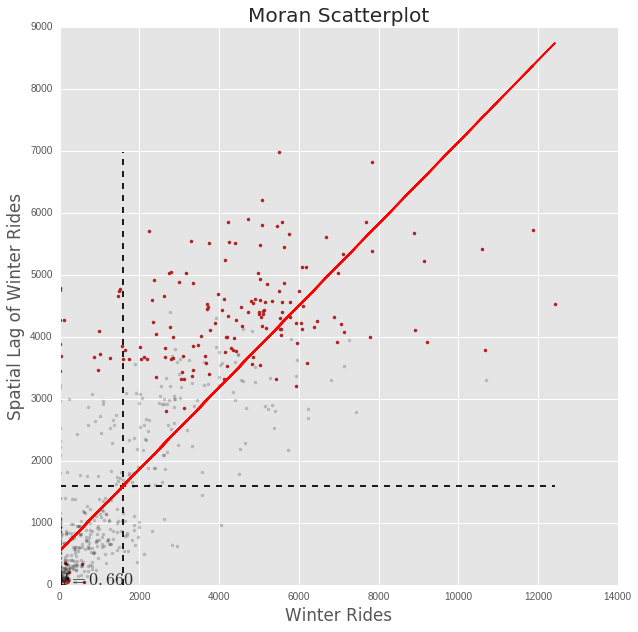

In [226]:
f, ax = plt.subplots(figsize=(10,10))
plt.plot(sigs, W_sigs, '.', color='firebrick')
plt.plot(insigs, W_insigs, '.k', alpha=.2)
plt.text(s='$I = %.3f$' % I_WinterRide.I, x=10, y=5, fontsize=18)

 # dashed vert at mean of the last year's PCI
plt.vlines(WinterRide.mean(), WinterRideLag.min(), WinterRideLag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(WinterRideLag.mean(), WinterRide.min(), WinterRide.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(WinterRide, a + b*WinterRide, 'r')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of Winter Rides')
plt.xlabel('Winter Rides')


### Hot and Cold spots 

In [227]:
sig = LMo_WinterRide.p_sim < 0.01
hotspots = LMo_WinterRide.q==1 * sig
coldspots = LMo_WinterRide.q==3 * sig
print "Number of Hotspots:", hotspots.sum()
print "Number of Coldspots:", coldspots.sum()

Number of Hotspots: 196
Number of Coldspots: 242


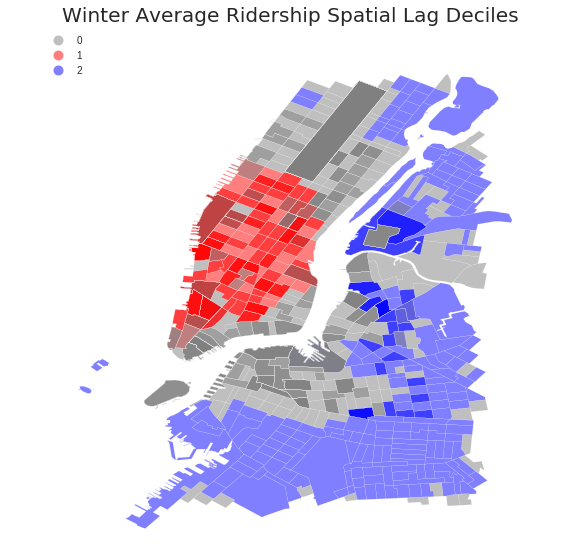

In [228]:
from matplotlib import colors

hcmap = colors.ListedColormap(['grey','red','blue'])
hotcold = hotspots*1 + coldspots*2

f, ax = plt.subplots(figsize=(9, 9))
ct_shape_WinterAve_Zoom.assign(cl=hotcold).plot(column='cl', categorical=True, 
        k=10, cmap=hcmap, linewidth=0.1, ax=ax, 
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title('Winter Average Ridership Spatial Lag Deciles')
plt.savefig('HW10_winter_zn352.png')

Figure 12 - Map of cold and hot spots, Average Citi Bike Ridership in Winter, NYC (2014-2016)